In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier #, MinCut2_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  include logger

In [2]:
#Training
model = MinCut2_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    burn_in=50)

/tmp/ipykernel_61133/3435653635.py:8: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with th.autograd.detect_anomaly():


Epoch 0: Training loss 14.4779, Validation loss 15.1218, learning rate 0.00100
		eadd_loss = 0.8245 vadd_loss = 0.9056
		Validation MAE: 14.7085
Epoch 5: Training loss 5.6809, Validation loss 15.1605, learning rate 0.00100
		eadd_loss = 0.8528 vadd_loss = 0.8204
		Validation MAE: 14.8629
Epoch 10: Training loss 4.2655, Validation loss 14.6449, learning rate 0.00100
		eadd_loss = 0.8912 vadd_loss = 0.8366
		Validation MAE: 14.3058
Epoch 15: Training loss 3.8833, Validation loss 14.8541, learning rate 0.00100
		eadd_loss = 1.0105 vadd_loss = 0.9670
		Validation MAE: 14.3931
Epoch 20: Training loss 3.5202, Validation loss 15.4957, learning rate 0.00100
		eadd_loss = 1.0663 vadd_loss = 1.0714
		Validation MAE: 14.9450
Epoch 25: Training loss 3.4543, Validation loss 15.5602, learning rate 0.00100
		eadd_loss = 1.0836 vadd_loss = 1.0845
		Validation MAE: 15.0007
Epoch 30: Training loss 3.0868, Validation loss 15.4875, learning rate 0.00100
		eadd_loss = 1.0971 vadd_loss = 1.0553
		Validation

KeyboardInterrupt: 

In [4]:
#get training run data

run_dir = "run_data/2022-05-09_9-19_DMoN_CG_Classifier"

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 22.3620 in epoch 143
Minimum Validation Loss (after 50 epochs) 35.7026 in epoch 256
Minimum MAE (after 50 epochs) 13.9494 in epoch 9515


Validation Loss at 9515 is 38.9544
5 before select
38.1904, 38.9565, 38.5511, 38.4842, 39.2091
5 after select
39.0043, 39.1382, 39.5754, 39.9409, 40.3753
MAE at 9515 is 13.9494


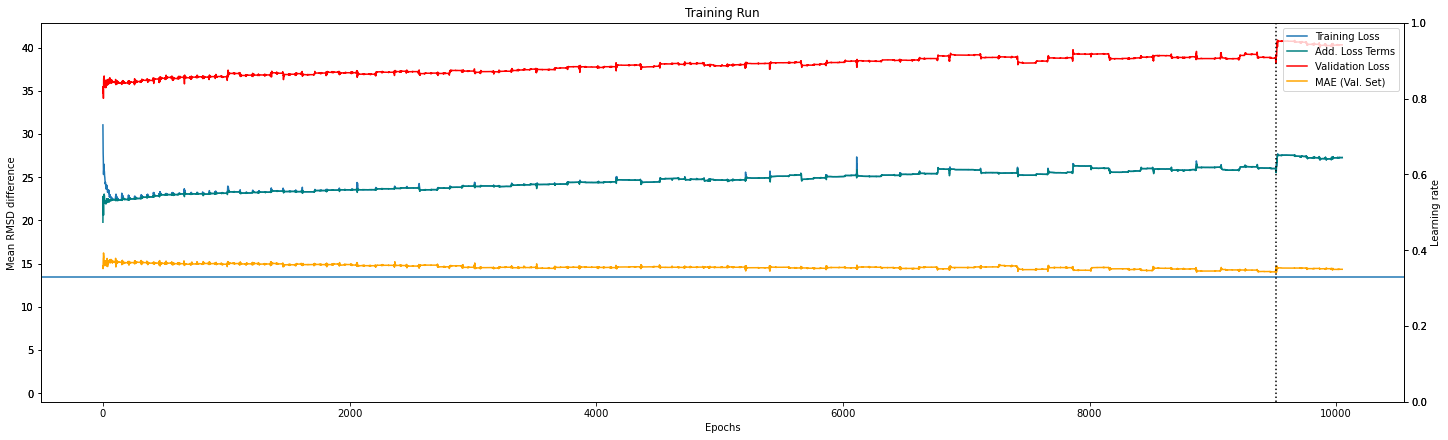

In [5]:
#plot the training run
select = 9515
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13.5)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
tensor([[18.3850]], device='cuda:0') tensor([[18.3088]], device='cuda:0') 0.0029004961252212524
tensor([[41.4410]], device='cuda:0') tensor([[11.5664]], device='cuda:0') 29.37457275390625
Mean Test loss: 	 12.2068
Std. Dev. of Test loss:  7.6393
Min loss: 		 0.0029
First Quantile: 	 6.3036
Median: 		 10.6038
Third Quantile: 	 18.4572
Max Loss: 		 29.3746
LinregressResult(slope=-0.5449715201494353, intercept=28.028928581525015, rvalue=-0.20459487954419428, pvalue=0.0006124255791731558, stderr=0.15722709755011893, intercept_stderr=3.3198756208847446)


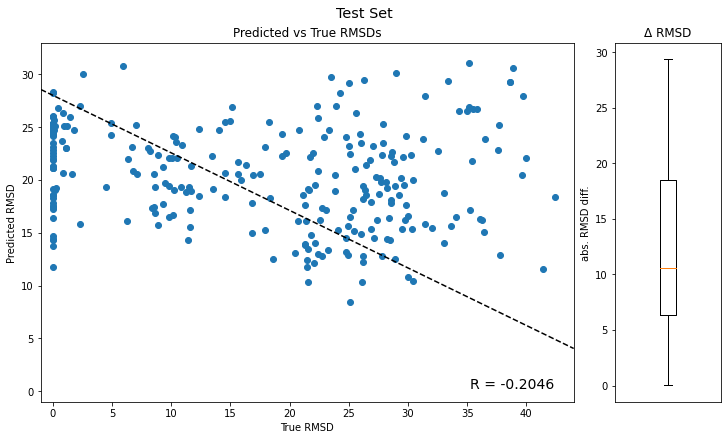

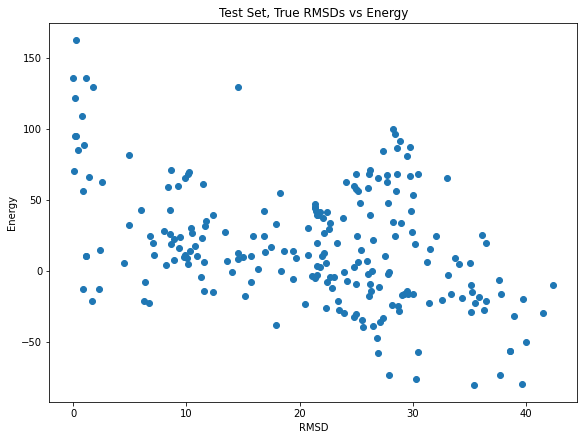

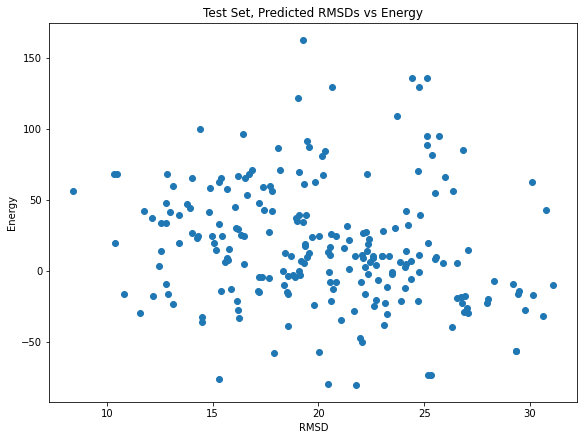

5S and tRNA Test Set
tensor([[18.0600]], device='cuda:0') tensor([[18.0484]], device='cuda:0') 6.677779310848564e-05
tensor([[0.]], device='cuda:0') tensor([[27.6010]], device='cuda:0') 27.101016998291016
Mean Test loss: 	 4.3130
Std. Dev. of Test loss:  4.9719
Min loss: 		 0.0001
First Quantile: 	 0.8908
Median: 		 2.5912
Third Quantile: 	 5.6659
Max Loss: 		 27.1010
LinregressResult(slope=0.8858125354560198, intercept=-0.22090960523860126, rvalue=0.6877831438962174, pvalue=1.4632939047250233e-152, stderr=0.028435701237640013, intercept_stderr=0.5535603378562757)


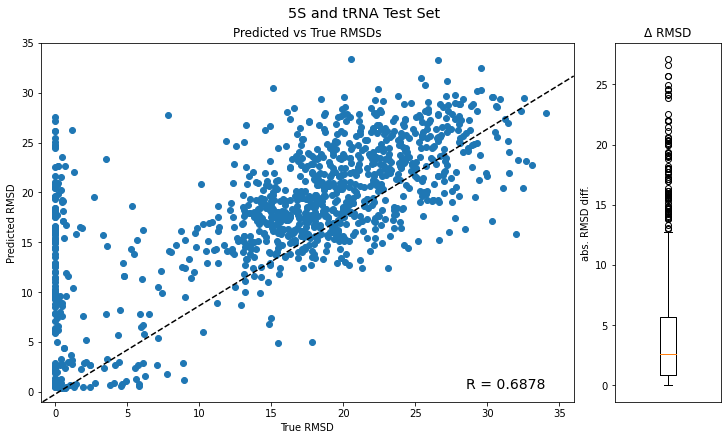

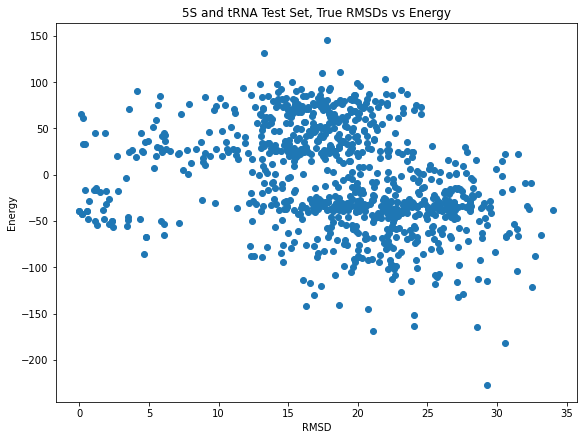

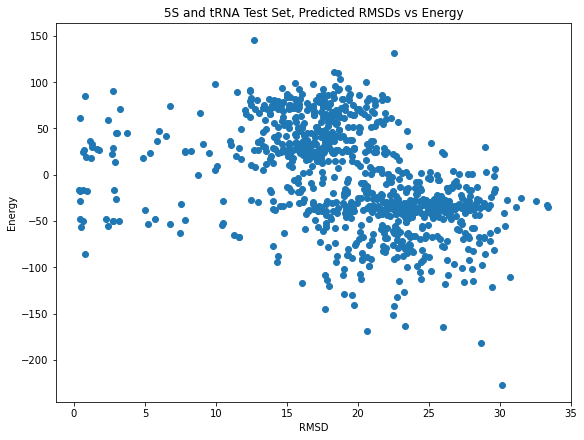

Training Set
tensor([[18.9760]], device='cuda:0') tensor([[18.9647]], device='cuda:0') 6.331902113743126e-05
tensor([[0.]], device='cuda:0') tensor([[23.0036]], device='cuda:0') 22.503585815429688
Mean Test loss: 	 1.2612
Std. Dev. of Test loss:  2.0823
Min loss: 		 0.0001
First Quantile: 	 0.1446
Median: 		 0.6634
Third Quantile: 	 1.5762
Max Loss: 		 22.5036
LinregressResult(slope=0.9988073850282677, intercept=-0.5972022140693483, rvalue=0.9576166951671349, pvalue=0.0, stderr=0.010912309419560456, intercept_stderr=0.22373521052128756)


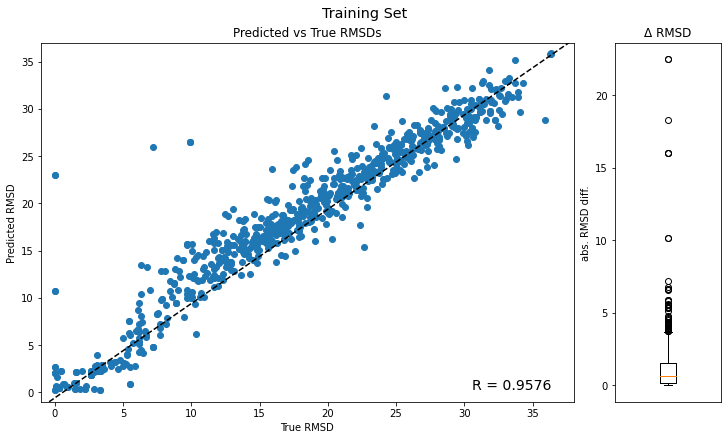

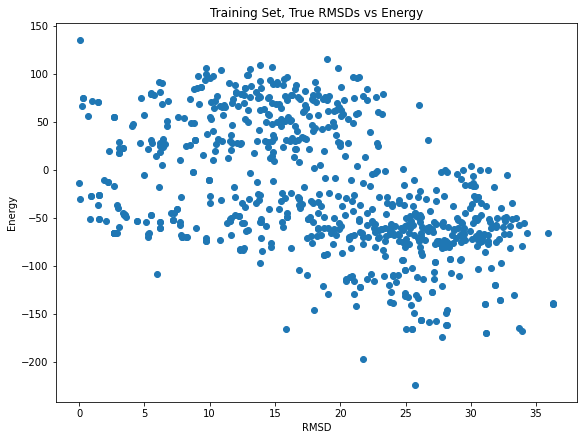

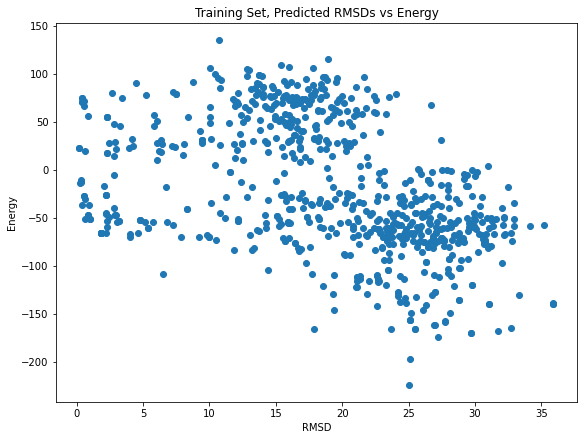

Validation Set
tensor([[15.3800]], device='cuda:0') tensor([[15.4300]], device='cuda:0') 0.0012477217242121696
tensor([[61.8180]], device='cuda:0') tensor([[16.4252]], device='cuda:0') 44.89277648925781
Mean Test loss: 	 12.9478
Std. Dev. of Test loss:  9.7383
Min loss: 		 0.0012
First Quantile: 	 4.3769
Median: 		 11.8253
Third Quantile: 	 19.3218
Max Loss: 		 44.8928
LinregressResult(slope=0.2043986243407033, intercept=18.7680896159042, rvalue=0.06737040460125197, pvalue=0.1809171100631205, stderr=0.15250106510815006, intercept_stderr=3.4363393550494026)


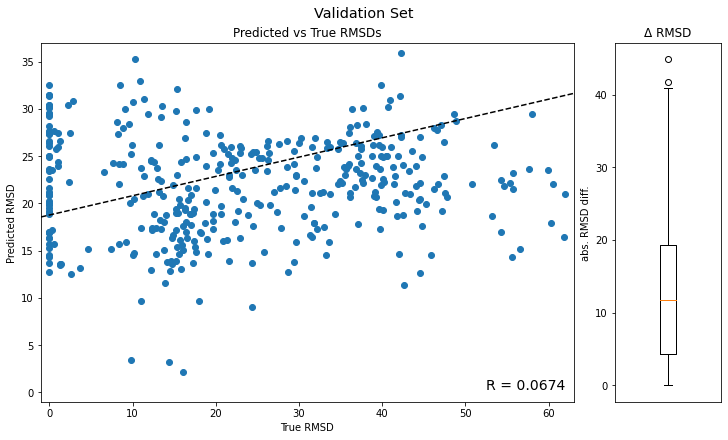

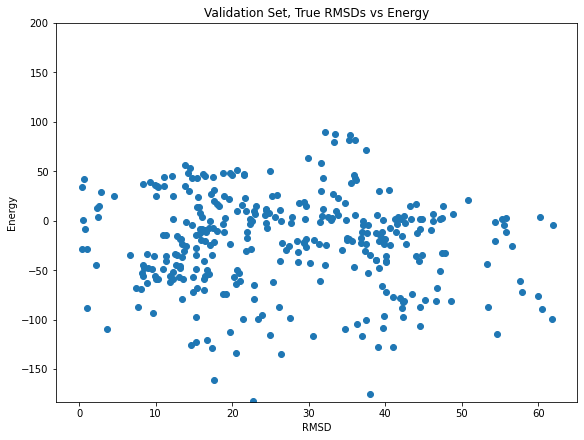

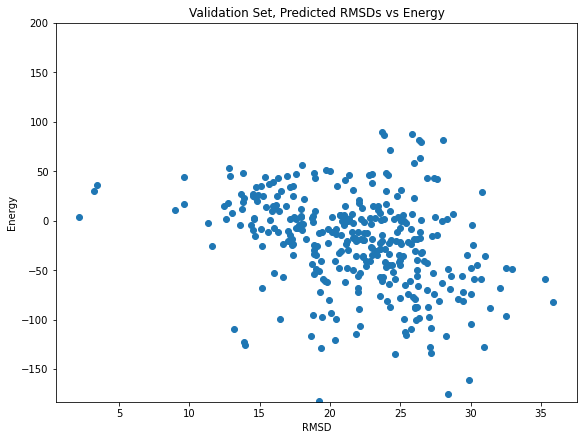

LinregressResult(slope=0.6531590318088131, intercept=7.718839806456764, rvalue=0.3736629783772545, pvalue=1.307931114372966e-50, stderr=0.042018026908301614, intercept_stderr=0.8770999384379555)


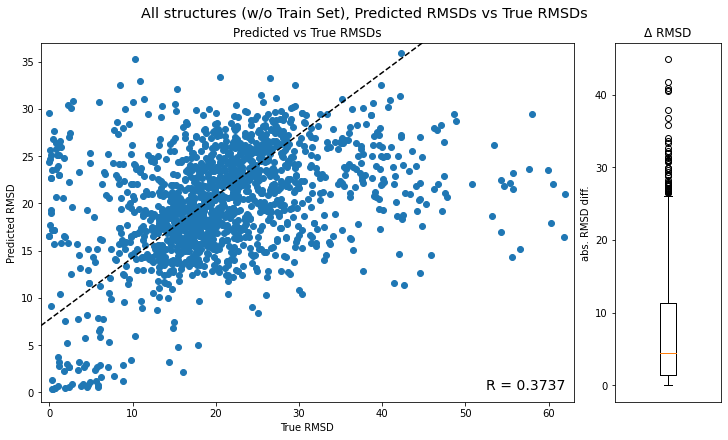

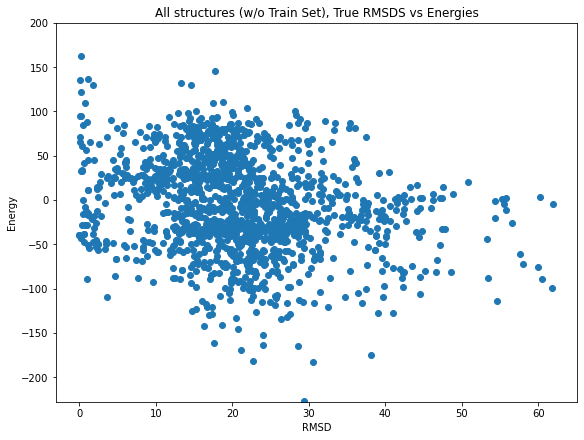

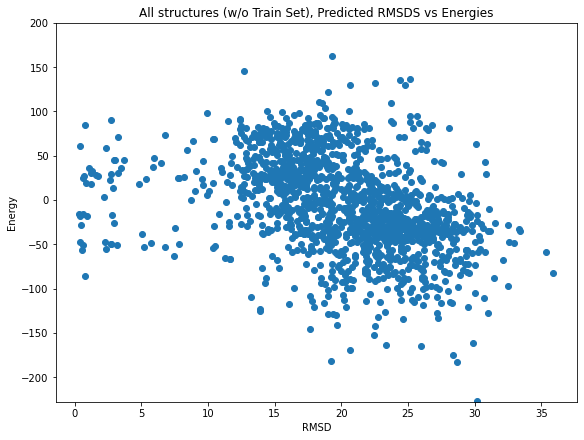

In [5]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9594764120095552, intercept=0.9498062348515859, rvalue=0.9642193937610933, pvalue=1.3733046511202001e-160, stderr=0.015907829874483755, intercept_stderr=0.3358964033833028)


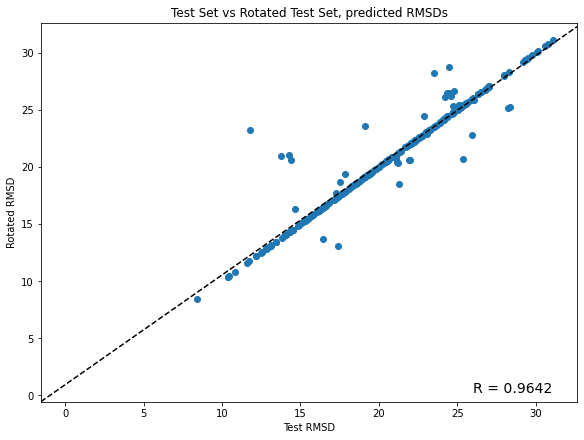

LinregressResult(slope=1.000085906271059, intercept=0.1148573568169855, rvalue=0.986611374478998, pvalue=1.2717899542193025e-218, stderr=0.009968947254733247, intercept_stderr=0.14355436575037928)


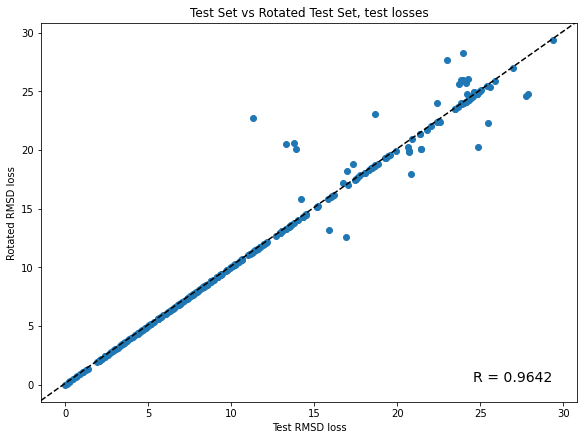

LinregressResult(slope=0.9459046093311229, intercept=1.1144539104374402, rvalue=0.9536610015085699, pvalue=0.0, stderr=0.009076917682429513, intercept_stderr=0.17670116790818752)


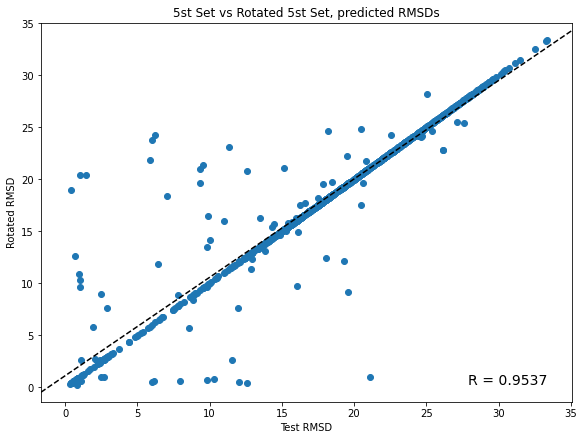

LinregressResult(slope=0.9656676642485449, intercept=0.2793978411235063, rvalue=0.9168766431510817, pvalue=0.0, stderr=0.01278682001523445, intercept_stderr=0.08416169374075845)


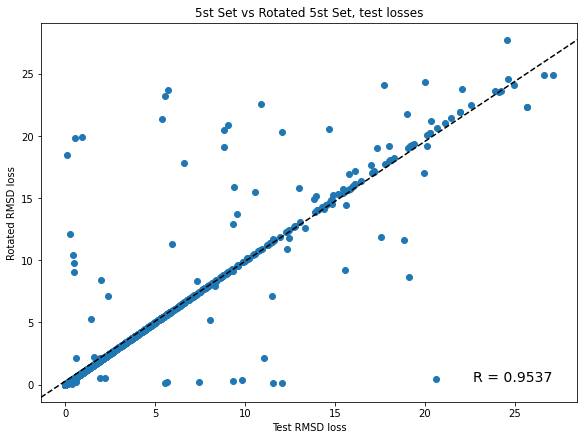

In [6]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")